In [1]:
import pandas as pd
import paramiko
import os
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

This notebook explores merged craigslist listings/census data and fits some initial models


## Remote connection parameters
If data is stored remotely

In [2]:
# TODO: add putty connection too. 

#read SSH connection parameters
with open('ssh_settings.json') as settings_file:    
    settings = json.load(settings_file)

hostname = settings['hostname']
username = settings['username']
password = settings['password']
local_key_dir = settings['local_key_dir']

census_dir = 'synthetic_population/'
"""Remote directory with census data"""

results_dir = 'craigslist_census/'
"""Remote directory for results"""

# estbalish SSH connection
ssh = paramiko.SSHClient() 
ssh.load_host_keys(local_key_dir)
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(hostname,username=username, password=password)
sftp = ssh.open_sftp()

# Data Preparation

In [2]:
def read_listings_file(fname):
    """Read csv file via SFTP and return as dataframe."""
    with sftp.open(os.path.join(listings_dir,fname)) as f:
        df = pd.read_csv(f, delimiter=',', dtype={'fips_block':str,'state':str,'mpo_id':str}, date_parser=['date'])
        # TODO: parse dates. 
    return df

def log_var(x):
    """Return log of x, but NaN if zero."""
    if x==0:
        return np.nan
    else:
        return np.log(x)
    
def create_census_vars(df):
    """Make meaningful variables and return the dataframe."""
    df['pct_white'] = df['race_of_head_1']/df['hhs_tot']
    df['pct_black'] = df['race_of_head_2']/df['hhs_tot']
    df['pct_amer_native'] = df['race_of_head_3']/df['hhs_tot']
    df['pct_alaska_native'] = df['race_of_head_4']/df['hhs_tot']
    df['pct_any_native'] = df['race_of_head_5']/df['hhs_tot']
    df['pct_asian'] = df['race_of_head_6']/df['hhs_tot']
    df['pct_pacific'] = df['race_of_head_7']/df['hhs_tot']
    df['pct_other_race'] = df['race_of_head_8']/df['hhs_tot']
    df['pct_mixed_race'] = df['race_of_head_9']/df['hhs_tot']
    df['pct_mover'] = df['recent_mover_1']/df['hhs_tot']
    df['pct_owner'] = df['tenure_1']/df['hhs_tot']
    df['avg_hh_size'] = df['persons_tot']/df['hhs_tot']
    df['cars_per_hh'] = df['cars_tot']/df['hhs_tot']
    
    df['ln_rent'] = df['rent'].apply(log_var)
    df['ln_income'] = df.income_med.apply(log_var)
    return df

def filter_outliers(df, rent_range=(100,10000),sqft_range=(10,5000)):
    """Drop outliers from listings dataframe. For now, only need to filter out rent and sq ft. 
    Args: 
        df: Dataframe with listings. Cols names include ['rent','sqft']
        rent_range (tuple): min and max rent
        sqft_range (tuple): min and max sqft
    Returns: 
        DataFrame: listings data without outliers. 
    """
    n0=len(df)
    df=df[(df.rent>=rent_range[0])&(df.rent<rent_range[1])]
    n1=len(df)
    print('Dropped {} outside rent range ${}-${}'.format(n0-n1,rent_range[0],rent_range[1]))
    df=df[(df.sqft>=sqft_range[0])&(df.sqft<sqft_range[1])]
    n2=len(df)
    print('Dropped {} outside sqft range {}-{} sqft. {} rows remaining'.format(n1-n2,sqft_range[0],sqft_range[1],len(df)))
    return(df)

In [3]:
# get list of files and load. 
# for remotely stored data by state (just do one state for now)
state='CA'
infile='cl_census_{}.csv'.format(state)
#data = read_listings_file(infile)  # uncomment to get remote data. 

# for local data: 
data_dir = '../data/'
data_file = 'sfbay_listings_03032017.csv'

data = pd.read_csv(os.path.join(data_dir,data_file),parse_dates=[1],dtype={'listing_id':str, 'rent':float, 'bedrooms':float, 'bathrooms':float, 'sqft':float,
       'rent_sqft':float, 'fips_block':str, 'state':str, 'region':str, 'mpo_id':str, 'lng':float, 'lat':float,
       'cars_tot':float, 'children_tot':float, 'persons_tot':float, 'workers_tot':float,
       'age_of_head_med':float, 'income_med':float, 'hhs_tot':float, 'race_of_head_1':float,
       'race_of_head_2':float, 'race_of_head_3':float, 'race_of_head_4':float, 'race_of_head_5':float,
       'race_of_head_6':float, 'race_of_head_7':float, 'race_of_head_8':float, 'race_of_head_9':float,
       'recent_mover_0':float, 'recent_mover_1':float, 'tenure_1':float, 'tenure_2':float})

print(len(data))
data.head()

82727


,listing_id,date,rent,bedrooms,bathrooms,sqft,rent_sqft,fips_block,state,region,...,race_of_head_4,race_of_head_5,race_of_head_6,race_of_head_7,race_of_head_8,race_of_head_9,recent_mover_0,recent_mover_1,tenure_1,tenure_2
0,5950749277,2017-01-08,3900.0,2.0,1.0,1000.0,3.900000,060750102001012,CA,sfbay,...,NaN,NaN,51.0,1.0,1.0,14.0,547.0,90.0,288.0,349.0
1,5930739630,2017-01-08,2107.0,2.0,1.5,1028.0,2.049611,060971506122048,CA,sfbay,...,NaN,NaN,11.0,2.0,19.0,19.0,536.0,25.0,264.0,297.0
2,5950748411,2017-01-08,3644.0,2.0,2.0,1362.0,2.675477,060855067033008,CA,sfbay,...,NaN,NaN,130.0,NaN,1.0,3.0,322.0,8.0,91.0,239.0
3,5950747869,2017-01-08,4350.0,2.0,1.0,900.0,4.833333,060750102001012,CA,sfbay,...,NaN,NaN,51.0,1.0,1.0,14.0,547.0,90.0,288.0,349.0
4,5950747694,2017-01-08,2450.0,3.0,2.0,1850.0,1.324324,060133270005038,CA,sfbay,...,NaN,1.0,27.0,2.0,16.0,25.0,634.0,25.0,547.0,112.0


In [4]:
# for census vars, NA really means 0...
census_cols = ['cars_tot', 'children_tot','persons_tot', 'workers_tot', 'age_of_head_med', 'income_med','hhs_tot', 'race_of_head_1', 'race_of_head_2', 'race_of_head_3','race_of_head_4', 'race_of_head_5', 'race_of_head_6', 'race_of_head_7','race_of_head_8', 'race_of_head_9', 'recent_mover_0', 'recent_mover_1','tenure_1', 'tenure_2']
for col in census_cols:
    data[col] = data[col].fillna(0)

## create variables
**variable codes**

Race codes (from PUMS)
1 .White alone
 2 .Black or African American alone
 3 .American Indian alone
 4 .Alaska Native alone
 5 .American Indian and Alaska Native tribes specified; or American
 .Indian or Alaska native, not specified and no other races
 6 .Asian alone
 7 .Native Hawaiian and Other Pacific Islander alone
 8 .Some other race alone
 9 .Two or more major race groups
 
 
 
 tenure_1 = owner (based on my guess; didn't match the PUMS codes)
 
 mover_1 = moved past year (based on my guess)

In [5]:
# create useful variables 
data = create_census_vars(data)

# define some feature to include in the model. 
features_to_examine = ['rent','ln_rent', 'bedrooms','bathrooms','sqft','pct_white', 'pct_black','pct_asian','pct_mover','pct_owner','income_med','age_of_head_med','avg_hh_size','cars_per_hh']
data[features_to_examine].describe()

,rent,ln_rent,bedrooms,bathrooms,sqft,pct_white,pct_black,pct_asian,pct_mover,pct_owner,income_med,age_of_head_med,avg_hh_size,cars_per_hh
count,8.272700e+04,82727.000000,82727.000000,21135.000000,82727.000000,82701.000000,82701.000000,82701.000000,82701.000000,82701.000000,82727.000000,82727.000000,82701.000000,82701.000000
mean,8.424425e+03,7.892339,1.786938,1.528507,1070.799352,0.614164,0.051737,0.251347,0.238773,0.444723,84269.025923,47.596722,2.392070,1.685853
std,8.079905e+05,0.415221,0.995156,0.658353,4395.502018,0.222690,0.100005,0.199291,0.134969,0.267616,35749.132951,7.469119,0.570091,0.477950
min,1.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.119074,0.084123
25%,2.125000e+03,7.661527,1.000000,1.000000,716.000000,0.445419,0.000000,0.087121,0.130178,0.238063,58000.000000,42.000000,1.973294,1.422348
50%,2.600000e+03,7.863267,2.000000,1.000000,930.000000,0.625000,0.014629,0.210407,0.231550,0.438642,79630.000000,48.000000,2.348315,1.764550
75%,3.308000e+03,8.104099,2.000000,2.000000,1187.000000,0.791878,0.050829,0.383133,0.333826,0.643371,105000.000000,53.000000,2.776371,2.007761
max,2.100204e+08,19.162715,8.000000,6.500000,985024.000000,1.000000,0.940909,0.950382,0.782759,1.000000,267500.000000,78.000000,5.241071,2.890467


## Filter outliers


In [6]:
# I've already identified these ranges as good at exluding outliers
rent_range=(100,10000)
sqft_range=(10,5000)
data = filter_outliers(data, rent_range=rent_range, sqft_range=sqft_range)

Dropped 386 outside rent range $100-$10000
Dropped 107 outside sqft range 10-5000 sqft. 82234 rows remaining


(0, 10000)

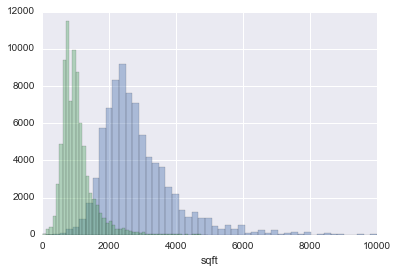

In [7]:
# Use this to explore outliers yourself. 
g=sns.distplot(data['rent'],  kde=False)
g.set_xlim(0,10000)

g=sns.distplot(data['sqft'], kde=False)
g.set_xlim(0,10000)

## Examine missing data

In [8]:
# examine NA's
print('Total rows:',len(data))
print('Rows with any NA:',len(data[pd.isnull(data).any(axis=1)]))
print('Rows with bathroom NA:',len(data[pd.isnull(data.bathrooms)]))
print('% rows missing bathroom col:',len(data[pd.isnull(data.bathrooms)])/len(data))

Total rows: 82234
Rows with any NA: 61242
Rows with bathroom NA: 61225
% rows missing bathroom col: 0.744521730671012


uh oh, 74% are missing bathrooms feature. Might have to omit that one. Only 0.02% of rows have other missing values, so that should be ok. 

In [9]:
#for d in range(1,31):
#    print(d,'% rows missing bathroom col:',len(data[pd.isnull(data.bathrooms)&((data.date.dt.month==12)&(data.date.dt.day==d))])/len(data[(data.date.dt.month==12)&(data.date.dt.day==d)]))

Bathrooms were added on Dec 21. After that, if bathrooms aren't in the listing, the listing is thrown out. Let's try to find the date when the bathrooms column was added. So if need to use bathrooms feature, can use listings Dec 22 and after.

In [10]:
# uncommon to only use data after Dec 21. 
#data=data[(data.date.dt.month>=12)&(data.date.dt.day>=22)]
#data.shape

In [11]:
# Uncomment to drop NA's
#data = data.dropna()
#print('Dropped {} rows with NAs'.format(n0-len(data)))



## Look at distributions

Since rent has a more or less logarithmic distribution, use ln_rent instead

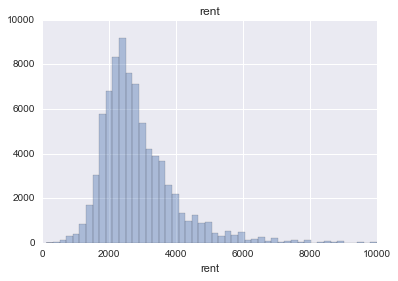

In [12]:
p=sns.distplot(data.rent, kde=False)
p.set_title('rent')

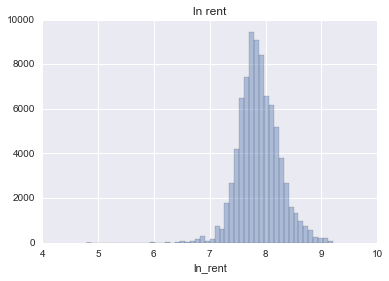

In [13]:
p=sns.distplot(data.ln_rent, kde=False)
p.set_title('ln rent')

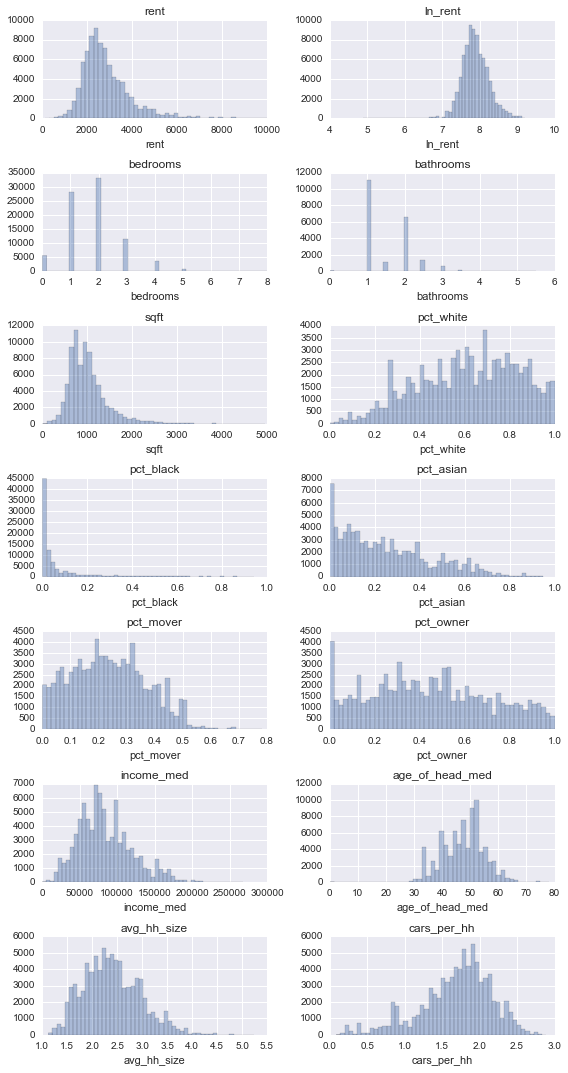

In [14]:
plot_rows = math.ceil(len(features_to_examine)/2)

f, axes = plt.subplots(plot_rows,2, figsize=(8,15))
sns.despine(left=True)

for i,col in enumerate(features_to_examine):
    row_position = math.floor(i/2)
    col_position = i%2
    data_notnull = data[pd.notnull(data[col])]  # exclude NA values from plot
    sns.distplot(data_notnull[col], ax=axes[row_position, col_position],kde=False)
    axes[row_position, col_position].set_title('{}'.format(col)) 

plt.tight_layout()
plt.show()

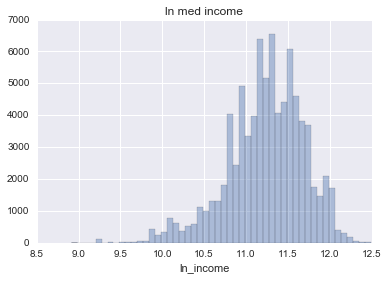

In [15]:
data_notnull = data[pd.notnull(data['ln_income'])]
p=sns.distplot(data_notnull['ln_income'],kde=False)
p.set_title('ln med income')
# ln med income is not more normal.. use med income instead. 

## look at correlations

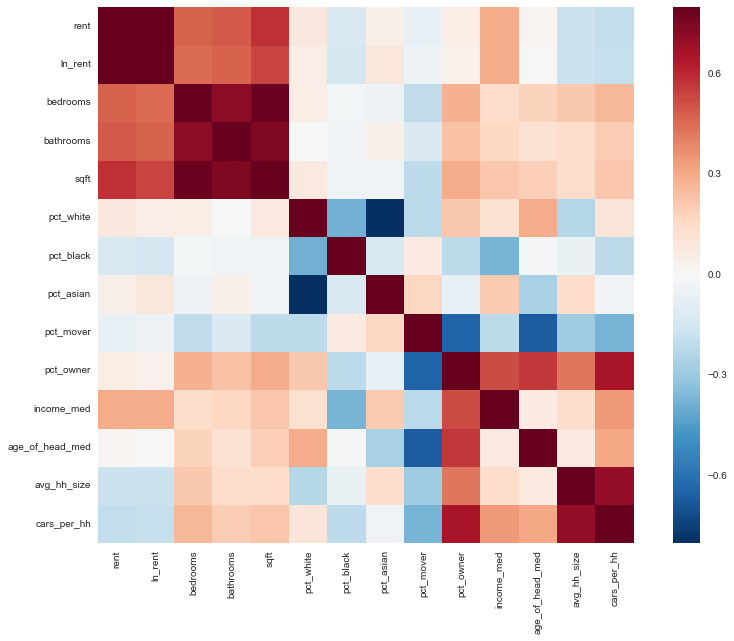

In [16]:
# correlation heatmap
corrmat=data[features_to_examine].corr()
corrmat.head()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

f.tight_layout()

The correlations appear as expected, except for cars_per_hh. Maybe this is because cars_per_hh is reflecting the size of the household more than income. Might want to try cars per adult instead..

In [17]:
print(data.columns)
#'pct_amer_native','pct_alaska_native',
x_cols = ['bedrooms','bathrooms', 'sqft','age_of_head_med', 'income_med','pct_white', 'pct_black', 'pct_any_native', 'pct_asian', 'pct_pacific',
       'pct_other_race', 'pct_mixed_race', 'pct_mover', 'pct_owner', 'avg_hh_size', 'cars_per_hh']
y_col = 'ln_rent'

print(len(data))

# exclude missing values
data_notnull= data[(pd.notnull(data[x_cols])).all(axis=1)]
data_notnull= data_notnull[(pd.notnull(data_notnull[y_col]))]
print('using {} rows of {} total'.format(len(data_notnull),len(data)))

Index(['listing_id', 'date', 'rent', 'bedrooms', 'bathrooms', 'sqft',
       'rent_sqft', 'fips_block', 'state', 'region', 'mpo_id', 'lng', 'lat',
       'cars_tot', 'children_tot', 'persons_tot', 'workers_tot',
       'age_of_head_med', 'income_med', 'hhs_tot', 'race_of_head_1',
       'race_of_head_2', 'race_of_head_3', 'race_of_head_4', 'race_of_head_5',
       'race_of_head_6', 'race_of_head_7', 'race_of_head_8', 'race_of_head_9',
       'recent_mover_0', 'recent_mover_1', 'tenure_1', 'tenure_2', 'pct_white',
       'pct_black', 'pct_amer_native', 'pct_alaska_native', 'pct_any_native',
       'pct_asian', 'pct_pacific', 'pct_other_race', 'pct_mixed_race',
       'pct_mover', 'pct_owner', 'avg_hh_size', 'cars_per_hh', 'ln_rent',
       'ln_income'],
      dtype='object')
82234
using 21006 rows of 82234 total


# Comparison of models

## Try a linear model

We'll start with a linear model to use as the baseline.

In [18]:
from sklearn import linear_model, cross_validation

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
# create training and testing datasets. 
# this creates a test set that is 30% of total obs.  
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data_notnull[x_cols],data_notnull[y_col], test_size = .3, random_state = 201)

In [21]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [22]:
# Intercept
print('Intercept:', regr.intercept_)

# The coefficients
print('Coefficients:')
pd.Series(regr.coef_, index=x_cols)

Intercept: 3.79537239111
Coefficients:


bedrooms           0.080902
bathrooms          0.084796
sqft               0.000223
age_of_head_med    0.000365
income_med         0.000003
pct_white          4.054088
pct_black          3.653897
pct_any_native    -2.392451
pct_asian          4.183934
pct_pacific        6.300127
pct_other_race     4.882282
pct_mixed_race     3.472586
pct_mover         -0.154455
pct_owner         -0.078191
avg_hh_size       -0.060285
cars_per_hh       -0.334151
dtype: float64

In [23]:
# See mean square error, using test data
print("Mean squared error: %.2f" % np.mean((regr.predict(X_test) - y_test) ** 2))
print("RMSE:", np.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_test, y_test))

Mean squared error: 0.06
RMSE: 0.245718331795
Variance score: 0.55


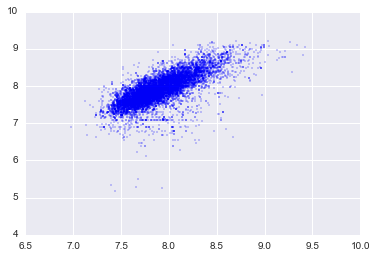

In [24]:
# Plot predicted values vs. observed
plt.scatter(regr.predict(X_train),y_train, color='blue',s=1, alpha=.5)
plt.show()

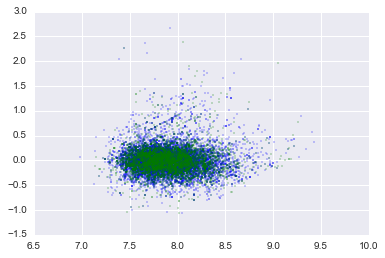

In [25]:
# plot residuals vs predicted values
plt.scatter(regr.predict(X_train), regr.predict(X_train)- y_train, color='blue',s=1, alpha=.5)
plt.scatter(regr.predict(X_test), regr.predict(X_test)- y_test, color='green',s=1, alpha=.5)
plt.show()

The residuals look pretty normally distributed.

I wonder if inclusion of all these race variables is leading to overfitting. If so, we'd have small error on training set and large error on test set. 

In [26]:
print("Training set. Mean squared error: %.5f" % np.mean((regr.predict(X_train) - y_train) ** 2), '| Variance score: %.5f' % regr.score(X_train, y_train))
print("Test set. Mean squared error: %.5f" % np.mean((regr.predict(X_test) - y_test) ** 2), '| Variance score: %.5f' % regr.score(X_test, y_test))

Training set. Mean squared error: 0.06211 | Variance score: 0.54432
Test set. Mean squared error: 0.06038 | Variance score: 0.54917


## Try Ridge Regression (linear regression with regularization )
Since the training error and test error are about the same, and since we're using few features, overfitting probably isn't a problem. If it were a problem, we would want to try a regression with regularization. 
Let's try it just for the sake of demonstration. 

In [27]:
from sklearn.linear_model import Ridge

In [28]:
# try a range of different regularization terms.
for a in [10,1,0.1,.01,.001,.00001]:
    ridgereg = Ridge(alpha=a)
    ridgereg.fit(X_train, y_train)
    
    print('\n alpha:',a)
    print("Mean squared error: %.5f" % np.mean((ridgereg.predict(X_test) - y_test) ** 2),'| Variance score: %.5f' % ridgereg.score(X_test, y_test))


 alpha: 10
Mean squared error: 0.06101 | Variance score: 0.54446

 alpha: 1
Mean squared error: 0.06070 | Variance score: 0.54678

 alpha: 0.1
Mean squared error: 0.06040 | Variance score: 0.54897

 alpha: 0.01
Mean squared error: 0.06035 | Variance score: 0.54936

 alpha: 0.001
Mean squared error: 0.06037 | Variance score: 0.54920

 alpha: 1e-05
Mean squared error: 0.06038 | Variance score: 0.54917


In [29]:
# Intercept
print('Intercept:', ridgereg.intercept_)

# The coefficients
print('Coefficients:')
pd.Series(ridgereg.coef_, index=x_cols)

Intercept: 3.79611296526
Coefficients:


bedrooms           0.080902
bathrooms          0.084796
sqft               0.000223
age_of_head_med    0.000365
income_med         0.000003
pct_white          4.053343
pct_black          3.653153
pct_any_native    -2.392905
pct_asian          4.183189
pct_pacific        6.299132
pct_other_race     4.881522
pct_mixed_race     3.471789
pct_mover         -0.154453
pct_owner         -0.078191
avg_hh_size       -0.060284
cars_per_hh       -0.334152
dtype: float64

As expected, Ridge regression doesn't help much. 
The best way to improve the model at this point is probably to add more features. 

## Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [26]:
def RMSE(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

def cross_val_rf(X, y,max_f='auto', n_trees = 50, cv_method='kfold', k=5):
    """Estimate a random forest model using cross-validation and return the average error across the folds.
    Args: 
        X (DataFrame): features data
        y (Series): target data
        max_f (str or int): how to select max features to consider for the best split. 
            If “auto”, then max_features=n_features.
            If “sqrt”, then max_features=sqrt(n_features)
            If “log2”, then max_features=log2(n_features)
            If int, then consider max_features features at each split
        n_trees (number of trees to build)
        cv_method (str): how to split the data ('kfold' (default) or 'timeseries')
        k (int): number of folds (default=5)
    Returns: 
        float: mean error (RMSE) across all training/test sets.
    """
    if cv_method == 'kfold':
        kf = KFold(n_splits=k, shuffle=True, random_state=2012016)  # use random seed for reproducibility. 
    
    E = np.ones(k)   # this array will hold the errors. 
    i=0
    for train, test in kf.split(X, y): 
        train_data_x = X.iloc[train]
        train_data_y = y.iloc[train]    
        test_data_x = X.iloc[test]
        test_data_y = y.iloc[test]

        # n_estimators is number of trees to build. 
        # max_features = 'auto' means the max_features = n_features. This is a parameter we should tune. 
        random_forest = RandomForestRegressor(n_estimators=n_trees, max_features=max_f, criterion='mse', max_depth=None)
        random_forest.fit(train_data_x,train_data_y)
        predict_y=random_forest.predict(test_data_x)
        E[i] = RMSE(test_data_y, predict_y)
        i+=1
    return np.mean(E)


def optimize_rf(df_X, df_y, max_n_trees=100, n_step = 20, cv_method='kfold', k=5): 
    """Optimize hyperparameters for a random forest regressor.
    Args: 
        df_X (DataFrame): features data
        df_y (Series): target data
        max_n_trees (int): max number of trees to generate
        n_step (int): intervals to use for max_n_trees
        cv_method (str): how to split the data ('kfold' (default) or 'timeseries')
        k (int): number of folds (default=5)
    """
    max_features_methods = ['auto','sqrt','log2']  # methods of defining max_features to try.
    
    # create a place to store the results, for easy plotting later. 
    results = pd.DataFrame(columns=max_features_methods, index=[x for x in range(10,max_n_trees+n_step,n_step)])
    
    for m in max_features_methods:
        print('max_features:',m)
        for n in results.index:
            error = cross_val_rf(df_X, df_y,max_f=m, n_trees=n)
            print('n_trees:',n,' error:',error)
            results.ix[n,m] = error
    return results

In [27]:
# data to use - exclude nulls
df_X = data_notnull[x_cols]
df_y = data_notnull[y_col]
print(df_X.shape, df_y.shape)
#df_all = pd.concat([data_notnull[x_cols],data_notnull[y_col]], axis=1)
#df_all.shape

(21006, 16) (21006,)


In [ ]:
# basic model to make sure it workds
random_forest = RandomForestRegressor(n_estimators=10, criterion='mse', max_depth=None)
random_forest.fit(df_X,df_y)
y_predict = random_forest.predict(df_X)
RMSE(df_y,y_predict)

We can use k-fold validation if we believe the samples are independently and identically distributed. That's probably fine right now because we have only 1.5 months of data, but later we may have some time-dependent processes in these timeseries data. If we do use k-fold, I think we should shuffle the samples, because they do not come in a non-random sequence.

In [ ]:
# without parameter tuning
cross_val_rf(df_X,df_y)

In [ ]:
# tune the parameters
rf_results = optimize_rf(df_X,df_y, max_n_trees = 100, n_step = 20)  # this is sufficient; very little improvement after n_trees=100. 
#rf_results2 = optimize_rf(df_X,df_y, max_n_trees = 500, n_step=100)
rf_results

In [ ]:
ax = rf_results.plot()
ax.set_xlabel('number of trees')
ax.set_ylabel('RMSE')
#rf_results2.plot()

Using m=sqrt(n_features) and log2(n_features) gives similar performance, and a slight improvement over m = n_features. After about 100 trees the error levels off. One of the nice things about random forest is that using additional trees doesn't lead to overfitting, so we could use more, but it's not necessary. Now we can fit the model using n_trees = 100 and m = sqrt.

In [ ]:
random_forest = RandomForestRegressor(n_estimators=100, max_features='sqrt', criterion='mse', max_depth=None)
random_forest.fit(df_X,df_y)
predict_y=random_forest.predict(df_X)

The 'importance' score provides an ordered qualitative ranking of the importance of each feature. It is calculated from the improvement in MSE provided by each feature when it is used to split the tree. 

In [ ]:
# plot the importances
rf_o = pd.DataFrame({'features':x_cols,'importance':random_forest.feature_importances_})
rf_o= rf_o.sort_values(by='importance',ascending=False)


plt.figure(1,figsize=(12, 6))
plt.xticks(range(len(rf_o)), rf_o.features,rotation=45)
plt.plot(range(len(rf_o)),rf_o.importance,"o")
plt.title('Feature importances')
plt.show()

It's not surprising sqft is the most important predictor, although it is strange cars_per_hh is the second most important. I would have expected incometo be higher in the list. 

If we don't think the samples are i.i.d., it's better to use time series CV. 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

## Try Boosted Forest

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

In [24]:
def cross_val_gb(X,y,cv_method='kfold',k=5, **params):
    """Estimate gradient boosting regressor using cross validation.
    
    Args: 
        X (DataFrame): features data
        y (Series): target data
        cv_method (str): how to split the data ('kfold' (default) or 'timeseries')
        k (int): number of folds (default=5)
        **params: keyword arguments for regressor
    Returns: 
        float: mean error (RMSE) across all training/test sets.
    """
    if cv_method == 'kfold':
        kf = KFold(n_splits=k, shuffle=True, random_state=2012016)  # use random seed for reproducibility. 
    
    E = np.ones(k)   # this array will hold the errors. 
    i=0
    for train, test in kf.split(X, y): 
        train_data_x = X.iloc[train]
        train_data_y = y.iloc[train]    
        test_data_x = X.iloc[test]
        test_data_y = y.iloc[test]

        # n_estimators is number of trees to build. 
        grad_boost = GradientBoostingRegressor(loss='ls',criterion='mse', **params)
        grad_boost.fit(train_data_x,train_data_y)
        predict_y=grad_boost.predict(test_data_x)
        E[i] = RMSE(test_data_y, predict_y)
        i+=1
    return np.mean(E)


In [41]:
params = {'n_estimators':100,
          'learning_rate':0.1,
          'max_depth':1,
          'min_samples_leaf':4
          }
grad_boost = GradientBoostingRegressor(loss='ls',criterion='mse', **params)
grad_boost.fit(df_X,df_y)
cross_val_gb(df_X,df_y, **params)

0.25199322945255337

In [ ]:
n_trees = 100
l_rate = 0.1
max_d = 1
cross_val_gb(df_X,df_y, l_rate,max_d)

### tune parameters

This time we'll use Grid Search in scikit-learn. This conducts an exhaustive search through the given parameters to find the best for the given estimator. 

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'learning_rate':[.1, .05, .02, .01],
              'max_depth':[2,4,6],
              'min_samples_leaf': [3,5,9,17],
              'max_features': [1, .3, .1]
              }

est= GradientBoostingRegressor(n_estimators = 1000)
gs_cv = GridSearchCV(est,param_grid).fit(df_X,df_y)

In [23]:
print(gs_cv.best_params_)
print(gs_cv.best_score_)

NameError: name 'gs_cv' is not defined

In [42]:
# best parameters
params = {'n_estimators':1000,
          'learning_rate':0.05,
          'max_depth':6,
          'min_samples_leaf':3
          }
grad_boost = GradientBoostingRegressor(loss='ls',criterion='mse', **params)
grad_boost.fit(df_X,df_y)
cross_val_gb(df_X,df_y, **params)

0.17111455700588998

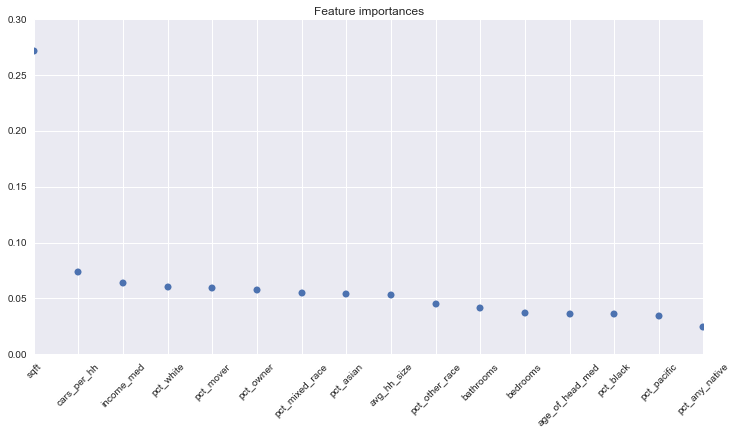

In [29]:
# plot the importances
gb_o = pd.DataFrame({'features':x_cols,'importance':grad_boost.feature_importances_})
gb_o= gb_o.sort_values(by='importance',ascending=False)


plt.figure(1,figsize=(12, 6))
plt.xticks(range(len(gb_o)), gb_o.features,rotation=45)
plt.plot(range(len(gb_o)),gb_o.importance,"o")
plt.title('Feature importances')
plt.show()

Let's use partial_dependence to look at feature interactions. Look at the four most important features. 

In [30]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

In [31]:
df_X.columns

Index(['bedrooms', 'bathrooms', 'sqft', 'age_of_head_med', 'income_med',
       'pct_white', 'pct_black', 'pct_any_native', 'pct_asian', 'pct_pacific',
       'pct_other_race', 'pct_mixed_race', 'pct_mover', 'pct_owner',
       'avg_hh_size', 'cars_per_hh'],
      dtype='object')

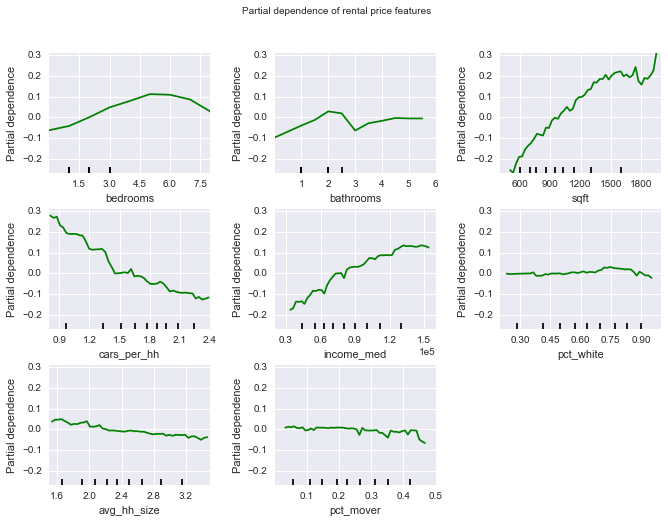

In [38]:
features = [0,1,2, 15, 4,5,14, 12]
names = df_X.columns
fig, axs = plot_partial_dependence(grad_boost, df_X, features,feature_names=names, grid_resolution=50, figsize = (10,8))
fig.suptitle('Partial dependence of rental price features')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle
plt.show()

The partial dependence plots show how predicted values vary with the given covariate, "controlling for" the influence of other covariates ([Friedman, 2001](http://www.jstor.org/stable/pdf/2699986.pdf)). In the top three plots above, we can see non-linear relationships between the features and predicted values. Bedrooms generally has a positive influence on rent, but it peaks at 5-6 bedrooms and then falls. With bedrooms, there is an interesting dip at 3 bedrooms. Perhaps this reflects lower rents for large shared houses that have many rooms that might be in older, poor-conditions buildings. 

The most important feature, sqft, has a generally positive influence on rent, except for a dip at the high end. Also interesting is the plot for income_med; rent increases with income, but levels off at the high end. Put another way, income of the neigborhood matters, up to a limit.

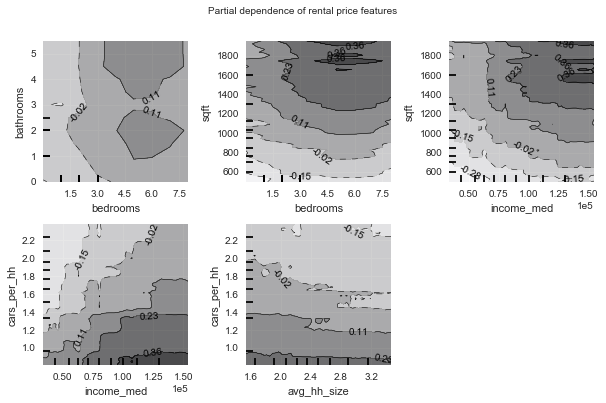

In [39]:
features = [(0,1),(0,2),(4,2), (4,15),(14,15)]
names = df_X.columns
fig, axs = plot_partial_dependence(grad_boost, df_X, features,feature_names=names, grid_resolution=50, figsize = (9,6))
fig.suptitle('Partial dependence of rental price features')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle
plt.show()